# Automated CAPTCHA Solving With Machine Learning

This notebook demonstrates the use of convolutional neural networks and supervised training to automate CAPTCHA-solving. 

Original Author: Jackon Yang (2017)

Further Modified By: Turhan Kimbrough (2021)

---

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd

In [2]:
data_directory = os.path.join(os.getcwd() + '/datasets/captcha_img')
image_height = 100
image_width = 100
image_channels = 3
categories = 10 # represents digits 0-9
dimensions = 4  # 4-digit CAPTCHA images

---
## Preparing the Dataset



In [3]:
def parse_file_path(file_path):
    """
    Args:
        file_path (str): the path to the CAPTCHA image
    
    Returns:
        the 'label' for each CAPTCHA denoted by the 
        string in the file name before the '_'
        character

        Example: file_name = 9876_image.png
                 Resulting label -> 9876 
    """
    try:
        path, file_name = os.path.split(file_path)
        file_name, extension = os.path.splitext(file_name)
        label, _ = file_name.split("_")
        return label
    except Exception as e:
        print('error while parsing %s. %s' % (file_path, e))
        return None, None

Store each CAPTCHA-image file path with its respective label
into a pandas DataFrame.

In [4]:
files = glob.glob(os.path.join(data_directory, "*.png"))
attributes = list(map(parse_file_path, files))

data_frame = pd.DataFrame(attributes)
data_frame['file'] = files
data_frame.columns = ['label', 'file']
data_frame = data_frame.dropna()
data_frame.head()

,label,file
0,4773,/home/t-visor/repositories/captcha-tensorflow/...
1,1562,/home/t-visor/repositories/captcha-tensorflow/...
2,8946,/home/t-visor/repositories/captcha-tensorflow/...
3,4378,/home/t-visor/repositories/captcha-tensorflow/...
4,8860,/home/t-visor/repositories/captcha-tensorflow/...


---
Shuffle the data and create a training set, validation set, and testing set.

In [5]:
shuffled_indeces = np.random.permutation(len(data_frame))
train_up_to = int(len(data_frame) * 0.7)
train_indices = shuffled_indeces[:train_up_to]
test_indices = shuffled_indeces[train_up_to:]

# Further split up the training data.
train_up_to = int(train_up_to * 0.7)
train_indices, validation_indices = train_indices[:train_up_to], train_indices[train_up_to:]

print('train count: %s, validation count: %s, test count: %s' % (
    len(train_indices), len(validation_indices), len(test_indices)))

train count: 3080, validation count: 1321, test count: 1887


---
## Neural Network Structure

**'relu'** stands for **'Rectified Linear Unit'**, the most commonly used activation function for convolutional neural networks.

**'softmax'** is another activation function used for classifying data.

Activation functions are analagous to the 'firing' of neurons in biological neural networks.

**Layers**:
- Convolutional layer: applies a filter to the CAPTCHA image to extract features (characters and/or digits) from the image
- Pooling layer: immediately follows a convolutional layer and used to downscale the image after each filter is applied
- Flattening layer: converts the CAPTCHA image represented as a 3D tensor (array) to a 1D tensor
- Dense layer: used to assist with operations on an n-dimensional tensor such as rotation, scaling, etc
- Reshape layer: used to restructure the output of the neural network

In [6]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model

input_layer = tf.keras.Input(shape=(image_height, image_width, image_channels))

hidden_layers = layers.Conv2D(32, 3, activation='relu')(input_layer)
hidden_layers = layers.MaxPooling2D((2, 2))(hidden_layers)
hidden_layers = layers.Conv2D(64, 3, activation='relu')(hidden_layers)
hidden_layers = layers.MaxPooling2D((2, 2))(hidden_layers)
hidden_layers = layers.Conv2D(64, 3, activation='relu')(hidden_layers)
hidden_layers = layers.MaxPooling2D((2, 2))(hidden_layers)

hidden_layers = layers.Flatten()(hidden_layers)

hidden_layers = layers.Dense(1024, activation='relu')(hidden_layers)
hidden_layers = layers.Dense(dimensions * categories, activation='softmax')(hidden_layers)
hidden_layers = layers.Reshape((dimensions, categories))(hidden_layers)

model = models.Model(inputs=input_layer, outputs=hidden_layers)

model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics= ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 64)        0     

---
## Training the Model

In [7]:
from tensorflow.keras.utils import to_categorical
from PIL import Image


def get_captcha_generator(data_frame, indices, for_training, batch_size=16):
    """    
    Args:
        data_frame (pandas.DataFrame): contains the file paths to the CAPTCHA images and their labels
        
        indices (int): specifies training indices, testing indices, or validation indices of the DataFrame
        
        for_training (bool): 'True' for training or validation set, 'False' to specify a test set 
        
        batch_size (int): number of data instances to return when iterated upon
    
    Returns:
        a generator object for producing CAPTCHA images along with their labels
        
    Yields:
        a pair of lists -> (CAPTCHA images, labels)
    """
    
    images, labels = [], []
    
    while True:
        for i in indices:
            captcha = data_frame.iloc[i]
            file, label = captcha['file'], captcha['label']
            captcha_image = Image.open(file)
            captcha_image = captcha_image.resize((image_height, image_width))
            captcha_image = np.array(captcha_image) / 255.0
            images.append(np.array(captcha_image))
            labels.append(np.array([np.array(to_categorical(int(i), categories)) for i in label]))
            if len(images) >= batch_size:
                yield np.array(images), np.array(labels)
                images, labels = [], []
        if not for_training:
            break

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size = 64
validation_batch_size = 64
training_set_generator = get_captcha_generator(data_frame, train_indices, \
                                               for_training=True, batch_size=batch_size)
validation_set_generator = get_captcha_generator(data_frame, validation_indices, \
                                                 for_training=True, batch_size=validation_batch_size)

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]

history = model.fit(training_set_generator,
                    steps_per_epoch=len(train_indices)//batch_size,
                    epochs=10,
                    validation_data=validation_set_generator,
                    validation_steps=len(validation_indices)//validation_batch_size)

Epoch 1/10
48/48 [==============================] - 18s 372ms/step - loss: 2.2832 - accuracy: 0.1614 - val_loss: 2.0463 - val_accuracy: 0.4014
Epoch 2/10
48/48 [==============================] - 17s 360ms/step - loss: 0.8379 - accuracy: 0.7583 - val_loss: 0.1624 - val_accuracy: 0.9512
Epoch 3/10
48/48 [==============================] - 17s 360ms/step - loss: 0.0512 - accuracy: 0.9879 - val_loss: 0.0592 - val_accuracy: 0.9842
Epoch 4/10
48/48 [==============================] - 17s 344ms/step - loss: 0.0110 - accuracy: 0.9979 - val_loss: 0.0432 - val_accuracy: 0.9887
Epoch 5/10
48/48 [==============================] - 17s 353ms/step - loss: 0.0048 - accuracy: 0.9995 - val_loss: 0.0389 - val_accuracy: 0.9904
Epoch 6/10
48/48 [==============================] - 19s 394ms/step - loss: 0.0017 - accuracy: 0.9997 - val_loss: 0.0410 - val_accuracy: 0.9902
Epoch 7/10
48/48 [==============================] - 18s 385ms/step - loss: 4.9764e-04 - accuracy: 1.0000 - val_loss: 0.0395 - val_accuracy: 0.

---
## Analyzing Model Performance

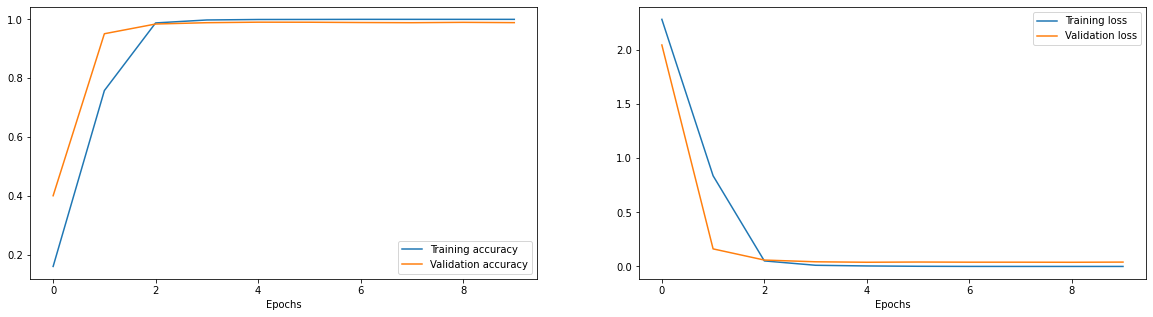

In [9]:
def plot_train_history(history):
    figure, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].plot(history.history['accuracy'], label='Training accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend() 

    axes[1].plot(history.history['loss'], label='Training loss')
    axes[1].plot(history.history['val_loss'], label='Validation loss')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

plot_train_history(history)

In [10]:
testing_set_generator = get_captcha_generator(data_frame, test_indices, for_training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate(testing_set_generator, steps=len(test_indices)//128)))

14/14 [==============================] - 3s 182ms/step - loss: 0.0475 - accuracy: 0.9863


{'loss': 0.0475015863776207, 'accuracy': 0.986328125}

---
## Evaluating Model on New Data

In [11]:
testing_set_generator = get_captcha_generator(data_frame, test_indices, for_training=False, batch_size=128)
captcha_images, captcha_text = next(testing_set_generator)

predictions = model.predict_on_batch(captcha_images)

true_values = tf.math.argmax(captcha_text, axis=-1)
predictions = tf.math.argmax(predictions, axis=-1)

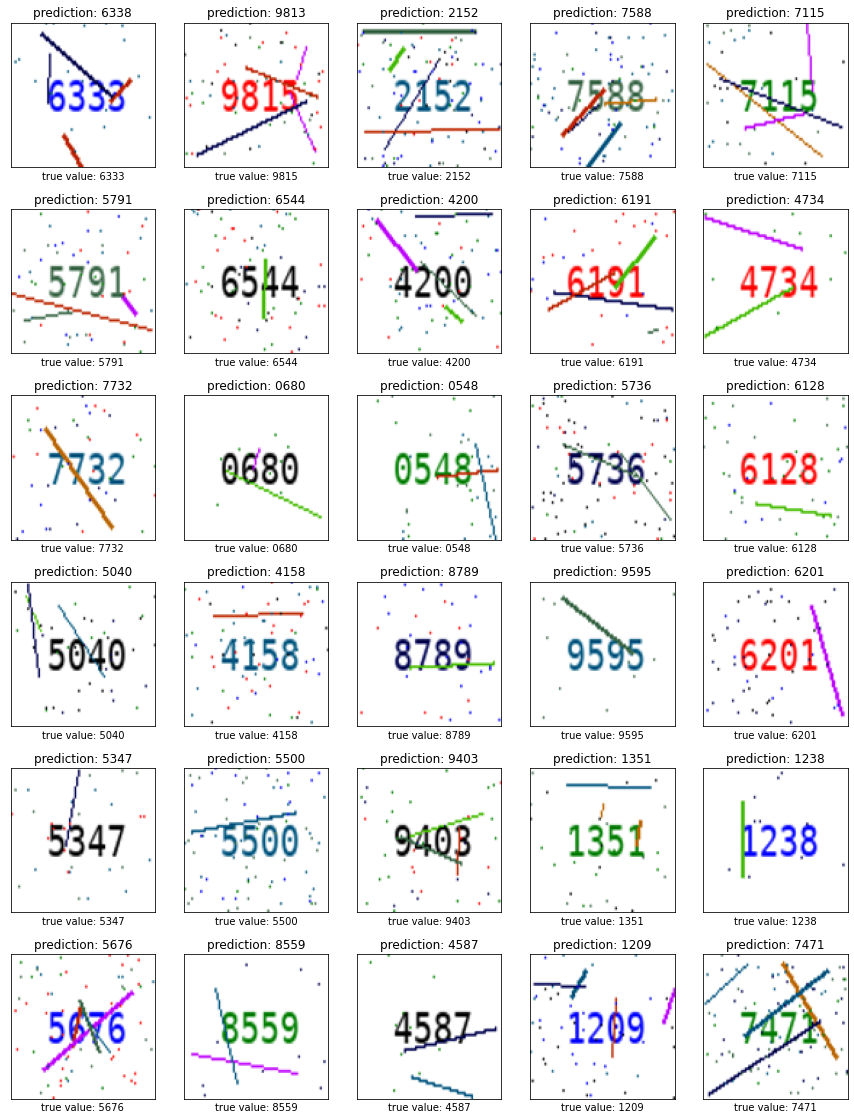

In [12]:
import math

total_to_display = 30
columns = 5
random_indices = np.random.permutation(total_to_display)
rows = math.ceil(total_to_display / columns)

figure, axes = plt.subplots(rows, columns, figsize=(15, 20))

for i, image_index in enumerate(random_indices):
    result = axes.flat[i]
    result.imshow(captcha_images[image_index])
    result.set_title('prediction: {}'.format(
        ''.join(map(str, predictions[image_index].numpy()))))
    result.set_xlabel('true value: {}'.format(
        ''.join(map(str, true_values[image_index].numpy()))))
    result.set_xticks([])
    result.set_yticks([])